# Using VGG16 to Classify Spectrograms

## Introduction

For this project, we want to explore how we can classify genres of music.  The challenge is to convert an audio file into a form of data that we know how to work with.

To do this, we will use what are called **spectrograms**.  Spectrograms are a graphical representation of the frequency content of a signal as it evolves over time.  It is a two-dimensional display where time is plotted on the x-axis, frequency on the y-axis, and the color or intensity represents the magnitude or amplitude of the signal's frequency components.  Spectrograms are widely employed in fields like signal processing and acoustics to analyze and visualize audio signals, providing insights into the changing frequencies within a given time frame.  This tool is crucial for tasks such as speech analysis, music processing, and various scientific and engineering applications where understanding the temporal and spectral characteristics of a signal is essential.

This report will provide a walkthrough of our analysis, from loading the data to our accuracy results.  As usual, we start with loading in all our libraries.

In [1]:
# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

# Plotting and Model Evaulation Libraries
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Utility Libraries
import numpy as np
import os

# Setting seed for reproducibility
keras.utils.set_random_seed(42) 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Loading

We now load in the spectrograms from our folder, and split them into training, validation, and test sets.

In [2]:
training_images_filepath = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original"
category_labels = os.listdir(training_images_filepath)

xdim = 180 
ydim = 180

spectograms = image_dataset_from_directory(
    training_images_filepath,
    image_size = (xdim, ydim),
    batch_size = 111)

## Use num_batches - 2 batches for training, 1 batch for validation, 1 batch for testing
num_batches = tf.data.experimental.cardinality(spectograms).numpy()
train = spectograms.take(num_batches - 2).cache()
remaining = spectograms.skip(num_batches - 2)
validation = remaining.take(1).cache()
test = remaining.skip(1).cache()

Found 999 files belonging to 10 classes.


Before continuing, we can get a sense of what some of our spectrograms look like. Below we will output the first five spectrograms in the validation set and their corresponding label.

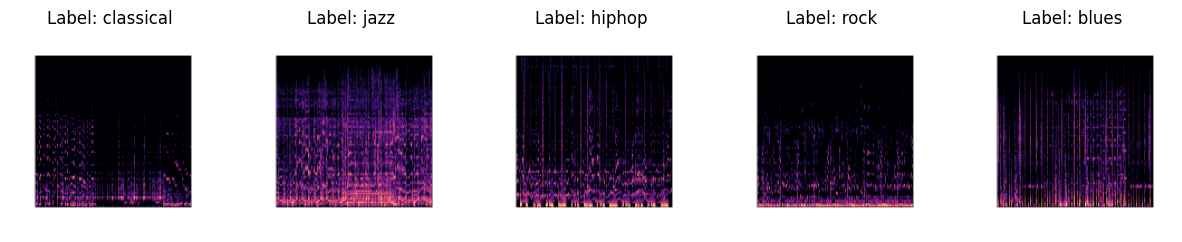

In [3]:
for images, labels in validation:
    plt.figure(figsize=(15, 500))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {category_labels[labels[i].numpy()]}")
        plt.axis("off")
    plt.show()

## Model Fine-Tuning

We will now start building the model to classify the spectrograms.  To do this, we will load in the VGG16 neural network and fine-tune it to suit our needs.

In [4]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (xdim, ydim, 3))
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

For the first step of our fine-tuning, we will freeze the base model and add in our own head to train.  What this means is that we will add in our own layers to the VGG16 model and ONLY train the weights of the new layers while keeping the weights of the original layers in VGG16 the same.  For now, we will just add a simple head with 256 nodes and a relu activation function.

Note that without a GPU, each epoch takes about 110 seconds to run.

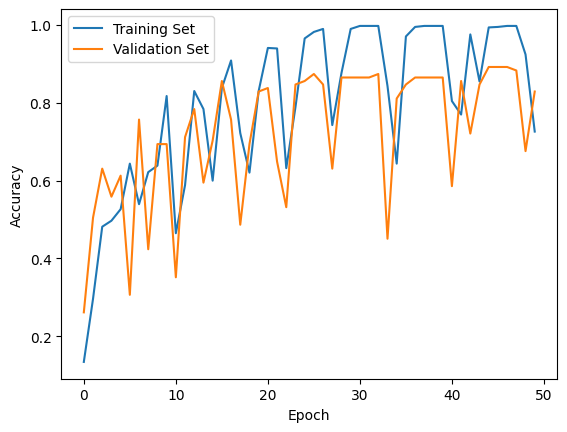

In [5]:
# Freeze the layers
conv_base.trainable = False 

# Define the new head
inputs = keras.Input(shape=(xdim, ydim, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation = "relu")(x)
outputs = layers.Dense(len(category_labels), activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

history = model.fit(
    train,
    epochs = 50,
    validation_data = validation,
    verbose = 0)

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Validation Set"]);

Now that the head of our model is moderately trained, we further fine-tune the model by unfreezing the last four layers of the VGG16 model and tuning them plus the head layers.

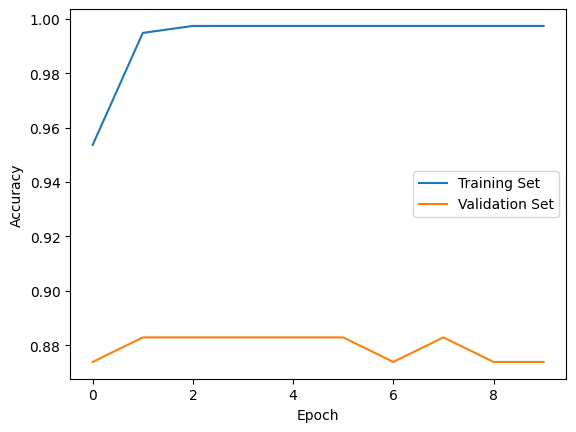

In [6]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train,
    epochs = 10,
    validation_data = validation,
    verbose = 0)

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Validation Set"]);

Fine-tuning in this step does not seem to improve the accuracy of the model further, but it is still an important step since it very well could have.

## Model Evaluation

Now that we have our model, we can test its performance on the test set.

In [7]:
predictions_prob = model.predict(test)
predictions = np.argmax(predictions_prob, axis = 1)

ground_truth = [label for _, label in test.unbatch()]
ground_truth = tf.stack(ground_truth, axis = 0).numpy()  

accuracy = accuracy_score(ground_truth, predictions)
print("Accuracy of the model:", accuracy)

1/1 [==============================] - 1s 1s/step
Accuracy of the model: 0.9009009009009009


We get an accuracy of just about 90%, which is very strong.  We can further analyze the performance by evaluating the confusion matrix.


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       1.00      1.00      1.00        11
           2       0.50      0.71      0.59         7
           3       0.86      1.00      0.92        12
           4       1.00      0.80      0.89         5
           5       0.86      1.00      0.92        12
           6       1.00      1.00      1.00        10
           7       1.00      0.94      0.97        18
           8       0.92      0.92      0.92        13
           9       1.00      0.62      0.76        13

    accuracy                           0.90       111
   macro avg       0.90      0.89      0.89       111
weighted avg       0.92      0.90      0.90       111



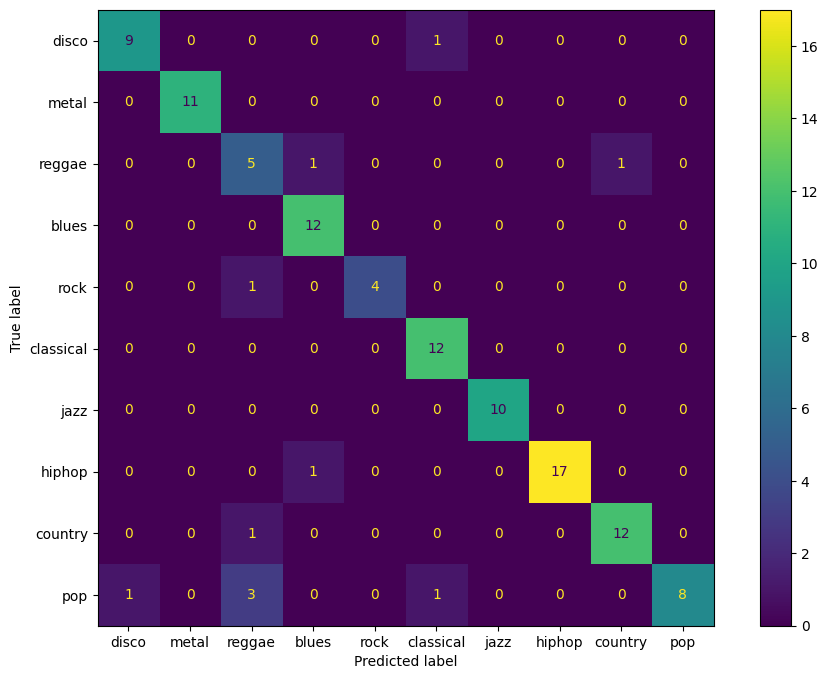

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
conf_matrix = confusion_matrix(ground_truth, predictions)
ConfusionMatrixDisplay(conf_matrix, display_labels = category_labels).plot(ax = ax)

report = classification_report(ground_truth, predictions)
print('\nClassification Report:\n', report)

From the confusion matrix we can see that most of our misclassifications are one-off misclassifications.  It is worth noting that pop appears to have the most misclassifications, which we can see on its low classification score.  The low score can make sense given how broad the pop genre can be.  

## Conclusion

In conclusion, our model demonstrated robust performance, underscoring the effectiveness of employing image classification techniques for the analysis of spectrographs in the context of audio file genre classification. This success implies broader applications beyond music genres, suggesting the viability of adapting similar approaches to diverse audio-related tasks. Beyond music, this methodology can be applied to other forms of audio classification challenges, such as voice recognition, distinguishing animal vocalizations, or diagnosing automotive issues based on the distinctive sounds they produce. Basically, any audio classification task can be transformed into an image classification task through the use of spectrographs. The versatility of image-based audio analysis showcases the potential for leveraging this technology across various domains.

## Sources

Audio Data: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

VGG16: https://arxiv.org/abs/1409.1556